In [1]:
import qiskit

In [2]:
pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

  Cloning https://github.com/qiskit-community/qiskit-textbook.git to c:\users\anirudh\appdata\local\temp\pip-req-build-0pb0omwv

  Created wheel for qiskit-textbook: filename=qiskit_textbook-0.1.0-py3-none-any.whl size=17069 sha256=8114ad8661ff30fd08a0135fefc76b450f9c64d935e32008867568615a24819e
  Stored in directory: C:\Users\ANIRUDH\AppData\Local\Temp\pip-ephem-wheel-cache-i8bcb8rr\wheels\80\c4\dd\b7ea1ee2a7247e8997db78bc777bbe22e61ab1e5ed1c4b46e1
Successfully built qiskit-textbook


In [3]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

#Import Qiskit classes 
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

In [4]:
#Generate RB circuits (2Q RB)

#number of qubits
nQ=2 
rb_opts = {}
#Number of Cliffords in the sequence
rb_opts['length_vector'] = [1, 10, 20, 50, 75, 100, 125, 150, 175, 200]
#Number of seeds (random sequences)
rb_opts['nseeds'] = 5
#Default pattern
rb_opts['rb_pattern'] = [[0, 1]]

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

In [5]:
rb_circs[0][0].draw()

┌───┐┌───┐┌───┐┌───┐      ░      ┌─────┐┌───┐┌─────┐┌───┐┌─┐
qr_0: ┤ Z ├┤ S ├┤ H ├┤ S ├──■───░───■──┤ SDG ├┤ H ├┤ SDG ├┤ Z ├┤M├
      ├───┤├───┤└───┘└───┘┌─┴─┐ ░ ┌─┴─┐└┬───┬┘├───┤└─┬─┬─┘└───┘└╥┘
qr_1: ┤ X ├┤ H ├──────────┤ X ├─░─┤ X ├─┤ H ├─┤ X ├──┤M├────────╫─
      └───┘└───┘          └───┘ ░ └───┘ └───┘ └───┘  └╥┘        ║ 
cr: 2/════════════════════════════════════════════════╩═════════╩═
                                                      1         0

In [6]:
# Create a new circuit without the measurement
qregs = rb_circs[0][-1].qregs
cregs = rb_circs[0][-1].cregs
qc = qiskit.QuantumCircuit(*qregs, *cregs)
for i in rb_circs[0][-1][0:-nQ]:
    qc.data.append(i)

In [7]:
# The Unitary is an identity (with a global phase)
backend = qiskit.Aer.get_backend('unitary_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
job = qiskit.execute(qc, backend=backend, basis_gates=basis_gates)
from qiskit_textbook.tools import array_to_latex
array_to_latex(np.around(job.result().get_unitary(),3), pretext="\\text{Unitary} = ")

<IPython.core.display.Math object>

In [8]:
# Run on a noisy simulator
noise_model = NoiseModel()

# Depolarizing error on the gates u2, u3 and cx (assuming the u1 is virtual-Z gate and no error)
p1Q = 0.002
p2Q = 0.01

noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

backend = qiskit.Aer.get_backend('qasm_simulator')

In [9]:
# Create the RB fitter
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] 
shots = 200
transpiled_circs_list = []
rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
for rb_seed, rb_circ_seed in enumerate(rb_circs):
    print('Compiling seed %d'%rb_seed)
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    transpiled_circs_list.append(new_rb_circ_seed)
    print('Simulating seed %d'%rb_seed)
    job = qiskit.execute(new_rb_circ_seed, backend, shots=shots,
                         noise_model=noise_model,
                         backend_options={'max_parallel_experiments': 0})    
    # Add data to the fitter
    rb_fit.add_data(job.result())
    print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))

Compiling seed 0
Simulating seed 0


<ipython-input-9-6b01d21c1ab0>:12: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.
  job = qiskit.execute(new_rb_circ_seed, backend, shots=shots,


After seed 0, alpha: 0.974894, EPC: 0.018830
Compiling seed 1
Simulating seed 1
After seed 1, alpha: 0.978334, EPC: 0.016249
Compiling seed 2
Simulating seed 2
After seed 2, alpha: 0.977641, EPC: 0.016770
Compiling seed 3
Simulating seed 3
After seed 3, alpha: 0.978061, EPC: 0.016454
Compiling seed 4
Simulating seed 4
After seed 4, alpha: 0.979448, EPC: 0.015414


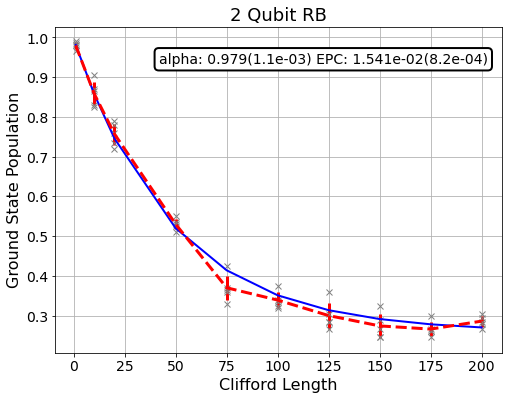

In [10]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rb_fit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit RB'%(nQ), fontsize=18)

plt.show()

In [11]:
# count the number of single and 2Q gates in the 2Q Cliffords
qubits = rb_opts['rb_pattern'][0]

gate_per_cliff = rb.rb_utils.gates_per_clifford(
    transpiled_circuits_list=transpiled_circs_list,
    clifford_lengths=xdata[0],
    basis=basis_gates,
    qubits=qubits)

for basis_gate in basis_gates:
    print("Number of %s gates per Clifford: %f"%(
        basis_gate,
        np.mean([gate_per_cliff[qubit][basis_gate] for qubit in qubits])))

Number of u1 gates per Clifford: 0.115502
Number of u2 gates per Clifford: 1.646288
Number of u3 gates per Clifford: 0.164738
Number of cx gates per Clifford: 1.440393


In [12]:
# convert from depolarizing error to epg (1Q)
epg_q0 = {'u1': 0, 'u2': p1Q/2, 'u3': 2 * p1Q/2}
epg_q1 = {'u1': 0, 'u2': p1Q/2, 'u3': 2 * p1Q/2}

# convert from depolarizing error to epg (2Q)
epg_q01 = 3/4 * p2Q

# calculate the predicted epc from underlying gate errors 
pred_epc = rb.rb_utils.calculate_2q_epc(
    gate_per_cliff=gate_per_cliff,
    epg_2q=epg_q01,
    qubit_pair=qubits,
    list_epgs_1q=[epg_q0, epg_q1])

print("Predicted 2Q Error per Clifford: %e (qasm simulator result: %e)" % (pred_epc, rb_fit.fit[0]['epc']))

Predicted 2Q Error per Clifford: 1.544210e-02 (qasm simulator result: 1.541437e-02)


In [13]:
# use 2Q EPC from qasm simulator result and 1Q EPGs from depolarizing error model
pred_epg = rb.rb_utils.calculate_2q_epg(
    gate_per_cliff=gate_per_cliff,
    epc_2q=rb_fit.fit[0]['epc'],
    qubit_pair=qubits,
    list_epgs_1q=[epg_q0, epg_q1])

print("Predicted 2Q Error per gate: %e (gate error model: %e)" % (pred_epg, epg_q01))

Predicted 2Q Error per gate: 7.464076e-03 (gate error model: 7.500000e-03)
